
# Convolutional Neural Network


Welcome to your fourth (last) assignment. You will train a convolutional neural network to classify images in this assignment. 

## Exercises:
1. $\color{violet}{\textbf{(10\%) Data Loading}}$
2. $\color{violet}{\textbf{(30\%) ConvNet Creation}}$
4. $\color{violet}{\textbf{(50\%) Training}}$
5. $\color{violet}{\textbf{(10\%) Evaluation}}$

## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. $\color{red}{\textbf{Do not modify code out of the designated area.}}$
- This assignment was originated from one of the [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

**You will learn:**

how to use PyTorch on
1. Loading built-in datasets and creating dataloaders 
2. Defining a Convolutional Neural Network
3. Defining a loss functions and an optimizer
4. Training a model.


## 1. Load Data
For this assignment, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


### $\color{violet}{\textbf{(10\%) Exercise 1: Data Loading}}$
1. Use `torchvision.datasets` to load CIFAR10 dataset into `train_set` and `test_set`.
2. Use `torch.utils.data.DataLoader` to create dataloaders for training data: `dataloader_train` and test data: `dataloader_test`.
3. Remeber to apply transforms on `train_set` and `test_set`

Number of training samples: 9469
Number of validation samples: 3925
Features shape: torch.Size([3, 160, 120])
Categories: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


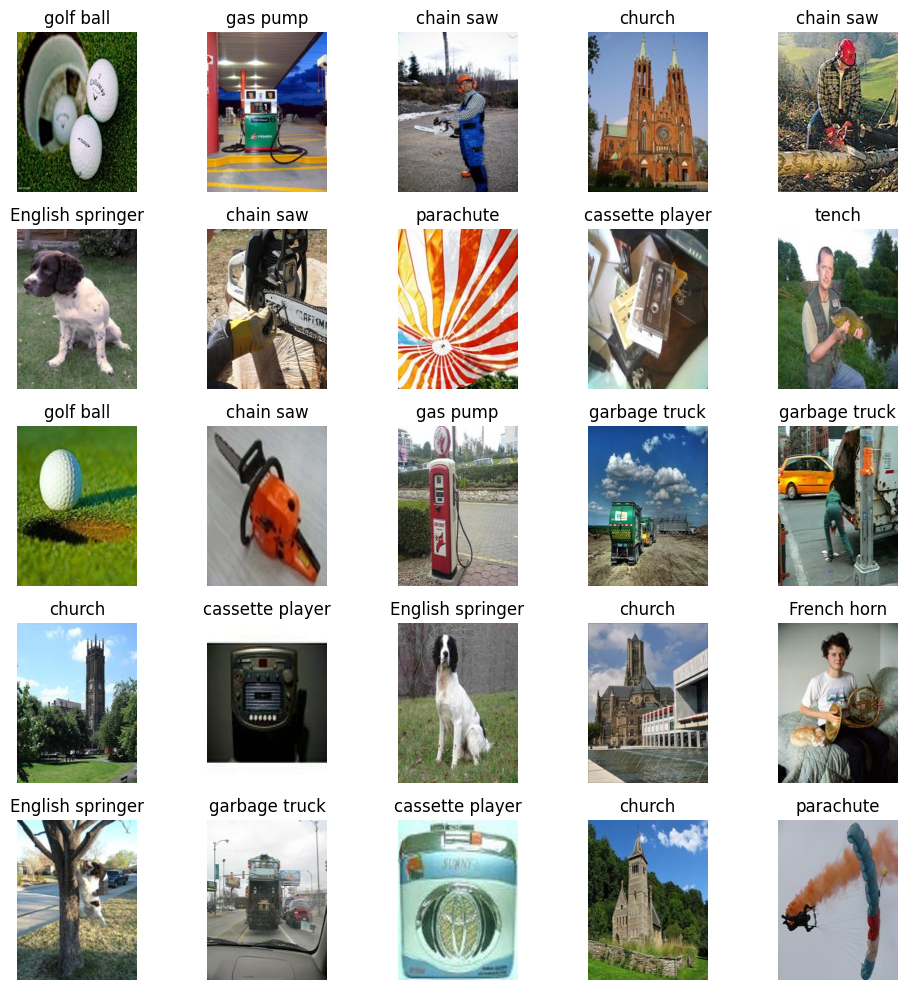

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import Compose, ToImage, RGB, Resize, ToDtype
import numpy as np
import matplotlib.pyplot as plt

# Construct transform pipeline for input features
transform_pipeline = Compose([
    ToImage(),
    RGB(),
    Resize((160, 120)),
    ToDtype(torch.float32, scale=True),
])

# Download datasets
dataset_train = datasets.Imagenette(
    root="data",
    split="train",
    size="160px",
    download=True,
    transform=transform_pipeline,
)

dataset_val = datasets.Imagenette(
   root="data",
    split="val",
    size="160px",
    download=True,
    transform=transform_pipeline,
)

labels = [c[0] for c in dataset_train.classes]

print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_val)}")
print(f"Features shape: {dataset_train[0][0].shape}")
print(f"Categories: {labels}")

# Create dataloaders
batch_size = 64
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


# Visualize data samples
sample_batch_train = next(iter(dataloader_train))
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    sample_img = sample_batch_train[0][i].permute(1, 2, 0).numpy()  # reconstruct image to (H, W, C)
    sample_cls = sample_batch_train[1][i].item()
    sample_lbl = labels[sample_cls]
    axs[i//5, i%5].imshow(sample_img)
    axs[i//5, i%5].set_title(sample_lbl)
    axs[i//5, i%5].axis("off")
plt.tight_layout()


## 2. Create a Convolutional Neural Network

### $\color{violet}{\textbf{(30\%) Exercise 2: ConvNet Creation}}$
1. Use four convolution kernels to transform images.
2. The 1st convolution kernel has size of (3, 3), and stride of (2, 2). It will output 32 channels of features tensors with shape (32, 15, 15).
3. The 2nd convolution kernel has size of (3, 3), and stride of (2, 2). It will output 64 channels of features tensors with shape (64, 7, 7).
4. The 3rd convolution kernel has size of (3, 3), and stride of (1, 1). It will output 128 channels of features tensors with shape (128, 5, 5).
5. The 4th convolution kernel has size of (2, 2), and stride of (1, 1). It will output 128 channels of features tensors with shape (128, 4, 4).


In [12]:
import torch.nn as nn


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv24 = nn.Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
        self.conv32 = nn.Conv2d(24, 32, kernel_size=(5, 5), stride=(2, 2))
        self.conv64_5 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
        self.conv64_3 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

        self.fc1 = nn.Linear(64*8*13, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv24(x))  
        x = self.relu(self.conv32(x))
        x = self.relu(self.conv64_5(x))
        x = self.relu(self.conv64_3(x))
        x = self.relu(self.conv64_3(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device}.")
model = ConvNet().to(device)  # use GPU if available
# print(model)
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 160, 120))

Using cuda.


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [64, 10]                  --
├─Conv2d: 1-1                            [64, 24, 78, 58]          1,824
├─ReLU: 1-2                              [64, 24, 78, 58]          --
├─Conv2d: 1-3                            [64, 32, 37, 27]          19,232
├─ReLU: 1-4                              [64, 32, 37, 27]          --
├─Conv2d: 1-5                            [64, 64, 17, 12]          51,264
├─ReLU: 1-6                              [64, 64, 17, 12]          --
├─Conv2d: 1-7                            [64, 64, 15, 10]          36,928
├─ReLU: 1-8                              [64, 64, 15, 10]          --
├─Conv2d: 1-9                            [64, 64, 13, 8]           (recursive)
├─ReLU: 1-10                             [64, 64, 13, 8]           --
├─Flatten: 1-11                          [64, 6656]                --
├─Linear: 1-12                           [64, 128]           

## 4. Training

### 4.1. Training Function

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



### 4.2. Validation Function

In [15]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():   
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### 4.3. Training Iteration

In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
model = ConvNet().to(device)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader_train, model, loss_fn, optimizer)
    validate(dataloader_val, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304024  [   64/ 9469]
loss: 2.219872  [ 3264/ 9469]
loss: 2.125170  [ 6464/ 9469]
Validation Error: 
 Accuracy: 27.2%, Avg loss: 2.004879 

Epoch 2
-------------------------------
loss: 1.969471  [   64/ 9469]
loss: 2.090591  [ 3264/ 9469]
loss: 1.907440  [ 6464/ 9469]
Validation Error: 
 Accuracy: 35.2%, Avg loss: 1.854271 

Epoch 3
-------------------------------
loss: 1.580065  [   64/ 9469]
loss: 1.840317  [ 3264/ 9469]
loss: 1.794053  [ 6464/ 9469]
Validation Error: 
 Accuracy: 41.1%, Avg loss: 1.696983 

Epoch 4
-------------------------------
loss: 1.614789  [   64/ 9469]
loss: 1.691042  [ 3264/ 9469]
loss: 1.455943  [ 6464/ 9469]
Validation Error: 
 Accuracy: 45.9%, Avg loss: 1.587952 

Epoch 5
-------------------------------
loss: 1.339252  [   64/ 9469]
loss: 1.422798  [ 3264/ 9469]
loss: 1.436068  [ 6464/ 9469]
Validation Error: 
 Accuracy: 48.9%, Avg loss: 1.502423 

Epoch 6
-------------------------------
loss: 1.426316  [   

# Congrats on finishing this assignment!